# <u> Introduction </u>

Hello! This is a project aimed at classifing and predicting Spam Emails. 

Please excuse me if there are some methods or codes that are wrong. Thank you!

The dataset used is from Kaggle. 

Dataset Credits: https://www.kaggle.com/datasets/venky73/spam-mails-dataset

My Github Repo: https://github.com/nrsfqh/Spam_Mail_Classifier_2023

My Github Page: https://github.com/nrsfqh

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as patches

# ML+ Metrics
# Might need to download stuff like 
#'punkt', ect, if you don't have it

#import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

#nltk.download('punkt')
#nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer
#nltk.download('wordnet')
#nltk.download('omw-1.4')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
import random



In [2]:
# Reading the file

spam_df = pd.read_csv('spam_ham_dataset.csv') 


## Data Exploration

In [3]:
spam_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [4]:
#Check for any missing values

spam_df.isnull().sum()

Unnamed: 0    0
label         0
text          0
label_num     0
dtype: int64

In [5]:
#Checking for duplicated records 

spam_df.duplicated().value_counts()

False    5171
dtype: int64

In [6]:
# Looking at the first few rows of the df

spam_df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


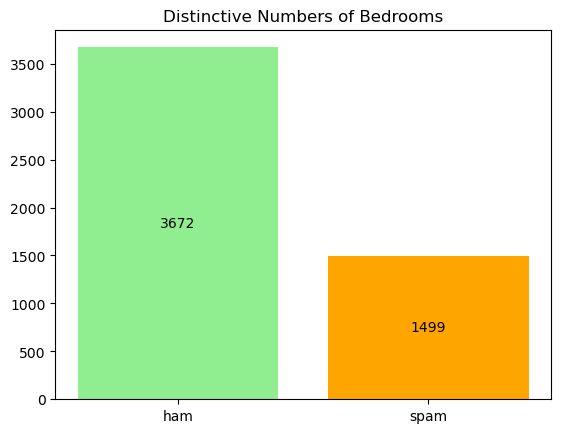

In [7]:
# Plot to show how many Spam and Ham there are

#Dinct. Value Counts
labels_col = spam_df["label"].value_counts()

# Bar Colors
bar_colors = ["lightgreen", "orange"]

# Plot the bar graph
bars = plt.bar(labels_col.index, labels_col.values, color = bar_colors)

# Title
plt.title("Distinctive Numbers of Bedrooms")

# To show value on top of bar graph. Loop through the patches and annotate the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height / 2, str(height), ha='center', va='center')

# Display the plot
plt.show()


#### **Insights:**

1) There's are 5171 E-Mails in this dataset, which should be more than enough to perform data classification. 

2) 3672 are non-spam while 1499 are spam

3) Dataset has no Missing Values and No Duplicated Records which is great.

In [8]:
# Let's view row 0 and 3 (as they are two different labels as during .head)
for index, row in spam_df.iterrows():
    
    # Check if the index is 0 or 3
    if index == 0 or index == 3:
        print(f"Label: {row['label']}\nText: {row['text']}\n")

Label: ham
Text: Subject: enron methanol ; meter # : 988291
this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary
flow data provided by daren } .
please override pop ' s daily volume { presently zero } to reflect daily
activity you can obtain from gas control .
this change is needed asap for economics purposes .

Label: spam
Text: Subject: photoshop , windows , office . cheap . main trending
abasements darer prudently fortuitous undergone
lighthearted charm orinoco taster
railroad affluent pornographic cuvier
irvin parkhouse blameworthy chlorophyll
robed diagrammatic fogarty clears bayda
inconveniencing managing represented smartness hashish
academies shareholders unload badness
danielson pure caffein
spaniard chargeable levin




#### **Insights:**

There's a few issues with the texts that I can identify such as

- Whitespace -> Best to just remove in case

- Stopwords (which do not contribute much when classifying)

- Lemmatization -> Return words to base/root form. Might help during Classification. 

Now let's try fixing the text.

## Data Cleaning

### Removing Whitespace

In [9]:
# Remove whitespace
# x -> each individual text
# Splits the text into individual words, then joins the words 
# back together into a single string
cleaned_text = spam_df["text"].apply(lambda x: " ".join(x.split()))

# Seeing the OG text
print("Original Text:")
print(spam_df["text"][0])

# New clean text
print("\nText with Whitespace Removed:")
print(cleaned_text[0])

Original Text:
Subject: enron methanol ; meter # : 988291
this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary
flow data provided by daren } .
please override pop ' s daily volume { presently zero } to reflect daily
activity you can obtain from gas control .
this change is needed asap for economics purposes .

Text with Whitespace Removed:
Subject: enron methanol ; meter # : 988291 this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary flow data provided by daren } . please override pop ' s daily volume { presently zero } to reflect daily activity you can obtain from gas control . this change is needed asap for economics purposes .


### Removing Stopwords

In [10]:
# Tokenize (Splits string into substrings)
tokenizer = RegexpTokenizer(r'\w+')
words = cleaned_text.apply(tokenizer.tokenize)

# Get the English stopwords
stop_words = set(stopwords.words('english'))

# Remove stopwords
# x -> words
# Keeps words not in stop_words
filtered_words = words.apply(lambda x: [word for word in x if word not in stop_words])

# Combine the words back into a single string
cleaned_text = filtered_words.apply(lambda x: " ".join(x))

print("Original Text:")
print(spam_df["text"][0])
print("\nText with Stopwords Removed:")
print(cleaned_text[0])

Original Text:
Subject: enron methanol ; meter # : 988291
this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary
flow data provided by daren } .
please override pop ' s daily volume { presently zero } to reflect daily
activity you can obtain from gas control .
this change is needed asap for economics purposes .

Text with Stopwords Removed:
Subject enron methanol meter 988291 follow note gave monday 4 3 00 preliminary flow data provided daren please override pop daily volume presently zero reflect daily activity obtain gas control change needed asap economics purposes


In [11]:
# Looking at the first few rows of the df again

spam_df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [12]:
# Looking at the first few rows of the df

cleaned_text.head()

0    Subject enron methanol meter 988291 follow not...
1    Subject hpl nom january 9 2001 see attached fi...
2    Subject neon retreat ho ho ho around wonderful...
3    Subject photoshop windows office cheap main tr...
4    Subject indian springs deal book teco pvr reve...
Name: text, dtype: object

We can see some symbols like "#", ";" and words such as "re" have been removed

### Lemmatizer

> Reducing a word to its base/root form

> I choose this over Stemming as Lemmatizer is more gramatically correct.

In [13]:
# Call the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Tokenize (Splits string into substrings)
tokenizer = RegexpTokenizer(r'\w+')
words = cleaned_text.apply(tokenizer.tokenize)

# Lemmatize
# Go thru each sentence in words, use lemmatizer on each word
lemmatized_words = words.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Combine the words back into a single string
cleaned_text = lemmatized_words.apply(lambda x: " ".join(x))

print("Original Text:")
print(spam_df["text"][0])
print("\nText with Stopwords Removed and Lemmatization:")
print(cleaned_text[0])


Original Text:
Subject: enron methanol ; meter # : 988291
this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary
flow data provided by daren } .
please override pop ' s daily volume { presently zero } to reflect daily
activity you can obtain from gas control .
this change is needed asap for economics purposes .

Text with Stopwords Removed and Lemmatization:
Subject enron methanol meter 988291 follow note gave monday 4 3 00 preliminary flow data provided daren please override pop daily volume presently zero reflect daily activity obtain gas control change needed asap economics purpose


In [14]:
cleaned_text

0       Subject enron methanol meter 988291 follow not...
1       Subject hpl nom january 9 2001 see attached fi...
2       Subject neon retreat ho ho ho around wonderful...
3       Subject photoshop window office cheap main tre...
4       Subject indian spring deal book teco pvr reven...
                              ...                        
5166    Subject put 10 ft transport volume decreased 2...
5167    Subject 3 4 2000 following noms hpl take extra...
5168    Subject calpine daily gas nomination julie men...
5169    Subject industrial worksheet august 2000 activ...
5170    Subject important online banking alert dear va...
Name: text, Length: 5171, dtype: object

### Joining back with df

In [15]:
#Create a new column in the original DataFrame with the cleaned_text data
spam_df["cleaned_text"] = cleaned_text

spam_df.head()

,Unnamed: 0,label,text,label_num,cleaned_text
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,Subject enron methanol meter 988291 follow not...
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,Subject hpl nom january 9 2001 see attached fi...
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,Subject neon retreat ho ho ho around wonderful...
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1,Subject photoshop window office cheap main tre...
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0,Subject indian spring deal book teco pvr reven...


In [16]:
spam_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    5171 non-null   int64 
 1   label         5171 non-null   object
 2   text          5171 non-null   object
 3   label_num     5171 non-null   int64 
 4   cleaned_text  5171 non-null   object
dtypes: int64(2), object(3)
memory usage: 202.1+ KB


## Data Splitting

In [17]:
# Initialize the CountVectorizer
cv = CountVectorizer()

In [18]:
# Y is target (label)
X = cv.fit_transform(spam_df["cleaned_text"])
y = spam_df["label"]

#Splitting data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)


print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4136, 47867) (1035, 47867) (4136,) (1035,)


## Model Selection

I will be doing a few different types of ML Algorithm and do a comparision later on.

> Logistic Regression

> Random Forest Classifier

> Gradient Boosting

> Support Vector Machine (SVM)

> Linear SVM

> KNN



### Logistic Regression

In [19]:
# Set up some parameters for LR
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']

# define grid search
grid = dict(solver=solvers,penalty=penalty)

# Call LR model
LR_model = LogisticRegression()

# GridSearchCV 
gridsearch_LR = GridSearchCV(LR_model, grid)


In [20]:
# Fit the model to the training data
gridsearch_LR.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']})

In [21]:
# Make predictions on the test data
y_pred_LR = gridsearch_LR.predict(X_test)

# Evaluate the model's performance
accuracy_LR = accuracy_score(y_test, y_pred_LR)
print("Accuracy:", accuracy_LR)

Accuracy: 0.9845410628019323


### Random Forest Classifier

In [22]:
# Set up some parameters for Random Forest 
max_features = ["sqrt", "log2"]
n_estimators = [10, 220, 20]

grid = dict(n_estimators=n_estimators, max_features=max_features)

# Call RFR
rfc = RandomForestClassifier(random_state=11)

# GridSearchCV 
gridsearch_rfc = GridSearchCV(rfc, grid, cv=5)

In [23]:
# Fit the model to the training data
gridsearch_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=11),
             param_grid={'max_features': ['sqrt', 'log2'],
                         'n_estimators': [10, 220, 20]})

In [24]:
# Predict on the test data
y_pred_RFC = gridsearch_rfc.predict(X_test)

# Evaluate the model's performance
accuracy_rfc = accuracy_score(y_test, y_pred_RFC)
print("Accuracy:", accuracy_rfc)


Accuracy: 0.9826086956521739


### Gradient Boosting

In [25]:
# Define the parameters for GB
learning_rate = [0.001, 0.01, 0.1]

grid = dict(learning_rate=learning_rate)

# Initialize the GradientBoostingClassifier
gbc = GradientBoostingClassifier()

# GridSearchCV
gridsearch_gbc = GridSearchCV(gbc, grid)

In [26]:
# Fit the model to the training data
gridsearch_gbc.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.001, 0.01, 0.1]})

In [27]:
# Make predictions on the test data
y_pred_GBC = gridsearch_gbc.predict(X_test)

# Evaluate the model's performance
accuracy_gb = accuracy_score(y_test, y_pred_GBC)
print("Accuracy:", accuracy_gb)

Accuracy: 0.9623188405797102


### SVM

In [28]:
# Define the parameters for SVM
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]

grid = dict(kernel=kernel,C=C)

# Call SVM
svm = SVC(random_state=11)

# GridSearch CV
gridsearch_svm = GridSearchCV(svm, grid)

In [29]:
# Fit the model to the training data
gridsearch_svm.fit(X_train, y_train)

GridSearchCV(estimator=SVC(random_state=11),
             param_grid={'C': [50, 10, 1.0, 0.1, 0.01],
                         'kernel': ['poly', 'rbf', 'sigmoid']})

In [30]:
# Make predictions on the test data
y_pred_SVM = gridsearch_svm.predict(X_test)

In [31]:
# Evaluate the model's performance
accuracy_svm = accuracy_score(y_test, y_pred_SVM)
print("Accuracy:", accuracy_svm)

Accuracy: 0.9768115942028985


### Linear SVM

In [32]:
# Define the parameters for LSVM
loss = ["hinge", "squared_hinge"]
C = [50, 10, 1.0, 0.1, 0.01]

grid = dict(loss=loss,C=C)

# Call SVM
lsvm = LinearSVC(random_state=11)

# GridSearch CV
gridsearch_lsvm = GridSearchCV(lsvm, grid)

In [33]:
# Fit the model to the training data
gridsearch_lsvm.fit(X_train, y_train)

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number 

GridSearchCV(estimator=LinearSVC(random_state=11),
             param_grid={'C': [50, 10, 1.0, 0.1, 0.01],
                         'loss': ['hinge', 'squared_hinge']})

In [34]:
# Make predictions on the test data
y_pred_lsvm = gridsearch_lsvm.predict(X_test)

In [35]:
# Evaluate the model's perf
accuracy_lsvm = accuracy_score(y_test, y_pred_lsvm)
print("Accuracy:", accuracy_lsvm)

Accuracy: 0.9777777777777777


### KNeighborsClassifier

In [36]:
# Define the parameters for KNN
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']

grid = dict(weights=weights,metric=metric)

# Call KNN
knnc = KNeighborsClassifier()

# GridSearch CV
gridsearch_knnc = GridSearchCV(knnc, grid)

In [37]:
# Fit the model to the training data
gridsearch_knnc.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'weights': ['uniform', 'distance']})

In [38]:
# Make predictions on the test data
y_pred_knnc = gridsearch_knnc.predict(X_test)

In [39]:
# Evaluate the model's performance
accuracy_knnc = accuracy_score(y_test, y_pred_knnc)
print("Accuracy:", accuracy_knnc)

Accuracy: 0.8434782608695652


## Comparision

In [40]:
acc_comparision = {
    "Model": ["Linear Regression (LR)", "Random Forest (RFC)", "Gradient Boosting (GB)", "SVM", "Linear SVM", "KNeighborsClassifier"],
    "Accuracy": [accuracy_LR, accuracy_rfc, accuracy_gb, accuracy_svm, accuracy_lsvm, accuracy_knnc]
}

# Create new pd DF to see
df_acc = pd.DataFrame(acc_comparision)

# Call
df_acc

,Model,Accuracy
0,Linear Regression (LR),0.984541
1,Random Forest (RFC),0.982609
2,Gradient Boosting (GB),0.962319
3,SVM,0.976812
4,Linear SVM,0.977778
5,KNeighborsClassifier,0.843478


### Insight

1) Linear Regression has the highest Accuracy of 98.4%.

2) From Most Accurate to Least:  LR, RFC, Linear SVM, SVM, GB, KNC

3) Generally, all of the Models have a high accuracy of more than 80%

In [41]:
# Looking at classification report 
print("\nLinear Regression :")
print(classification_report(y_test, y_pred_LR))


Linear Regression :
              precision    recall  f1-score   support

         ham       1.00      0.98      0.99       744
        spam       0.96      0.99      0.97       291

    accuracy                           0.98      1035
   macro avg       0.98      0.99      0.98      1035
weighted avg       0.98      0.98      0.98      1035



### Insight

- Firstly, Precision measures the true positive predictions. When LR predicts an email as "ham," it is 100% correct while if it predicts an email as "spam," it is 96% correct. Even though both are not 100% accurate, these are still very high precision scores.

- Recall -> Measure model on how it correctly identifying True Positives. Model correctly identifies 98% of "ham" emails and 99% of "spam" emails.

- F1-score -> Harmonic mean of the Precision and Recall.

- In Conclusion, this LR model is very reliable in classifying emails as it has high precision, recall and F1-scores.

## Examples of Prediction

In [42]:
# Randomly select any two indices from the dataset
random_indices = random.sample(range(len(spam_df)), 2)

# Declare text and lebel column
texts = spam_df.iloc[random_indices]["text"]
labels = spam_df.iloc[random_indices]["label"]

# Transform the texts using cv
X_random = cv.transform(texts)

# Use LR models to make prediction on the random text
predicted_labels_lr = gridsearch_LR.predict(X_random)

# Print only 2 emails
for i in range(2):
    print("Text:", texts.iloc[i])
    print("\nActual Label:", labels.iloc[i])
    print("\nLR Prediction Label:", predicted_labels_lr[i])
    print ("---")


Text: Subject: calpine daily gas nomination
>
ricky a . archer
fuel supply
700 louisiana , suite 2700
houston , texas 77002
713 - 830 - 8659 direct
713 - 830 - 8722 fax
- calpine daily gas nomination 1 . doc

Actual Label: ham

LR Prediction Label: ham
---
Text: Subject: 
hello ,
i sent you an email a few days ago because you now qualify for a new mortgage .
you could get $ 300 , 000 for as little as $ 700 a month !
bad credit is no problem , you can pull cash out or refinance .
best regards ,
candy hastings
no thanks
or snail mail :
rua dcoa imstprense , 4 l 34 o 7 , r / c bloco 1 - lk 33 map } utou , m { oz 6 aambique


Actual Label: spam

LR Prediction Label: spam
---
